In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import os.path as op
import numpy as np

from bauer.utils.math import softplus_np
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np

from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']


bids_folder  = '/data/ds-tmsrisk'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):
    df = get_data(bids_folder, model_label)
    model = build_model(model_label, df)
    model.build_estimation_model()
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

def get_pars(idata, group=True):
    traces = {}

    pars_vertex = []
    pars_ips = []

    keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

    for key in keys:

        if group:
            key_ = key+'_mu'
        else:
            key_ = key

        traces[key] = idata.posterior[f'{key_}'].to_dataframe()

        ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')

        if 'stimulation_condition[T.vertex]' in traces[key].index.get_level_values(f'{key}_regressors'):
            vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
        else:
            vertex_values = ips_values

        if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
            ips_values = softplus_np(ips_values)
            vertex_values = softplus_np(vertex_values)

        pars_ips.append(ips_values)
        pars_vertex.append(vertex_values)


    pars_ips = pd.concat(pars_ips, axis=1)
    pars_vertex = pd.concat(pars_vertex, axis=1)

    pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
    pars.columns.name = 'parameter'
    pars = pars.stack().to_frame('value')

    return pars


def plot_pars(pars, df, ):
    g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
    g.set_titles('{col_name}')


    g.axes.flat[2].axhline(np.log(df['n_risky'].mean()), color='k', linestyle='--')
    g.axes.flat[3].axhline(np.log(df['n_risky'].std()), color='k', linestyle='--')
    g.axes.flat[4].axhline(np.log(df['n_safe'].mean()), color='k', linestyle='--')
    g.axes.flat[5].axhline(np.log(df['n_safe'].std()), color='k', linestyle='--')

    return g


def plot_pars_diff(pars):
    tmp = pars.unstack('stimulation condition')['value']
    tmp = tmp['IPS'] - tmp['Vertex']
    g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

    g.map(sns.kdeplot, 'diff', fill=True, color='k')

    g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

    g.set_titles('{col_name}')

    for ax, par in zip(g.axes.flat, g.col_names):
        p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
        
        if p != 0.0:
            ax.text(0.7, 0.8, f'p={p:0.3f}',
            horizontalalignment='left',
            fontsize=10,
            verticalalignment='center',
            transform = ax.transAxes)

    return g


def get_ppc(model, idata):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)

In [3]:
model_label = '1'
df = get_data(model_label=model_label)
model = build_model(model_label, df)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [4]:
bids_folder  = '/data/ds-tmsrisk'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

# Model 1

In [5]:
model_label = '1'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


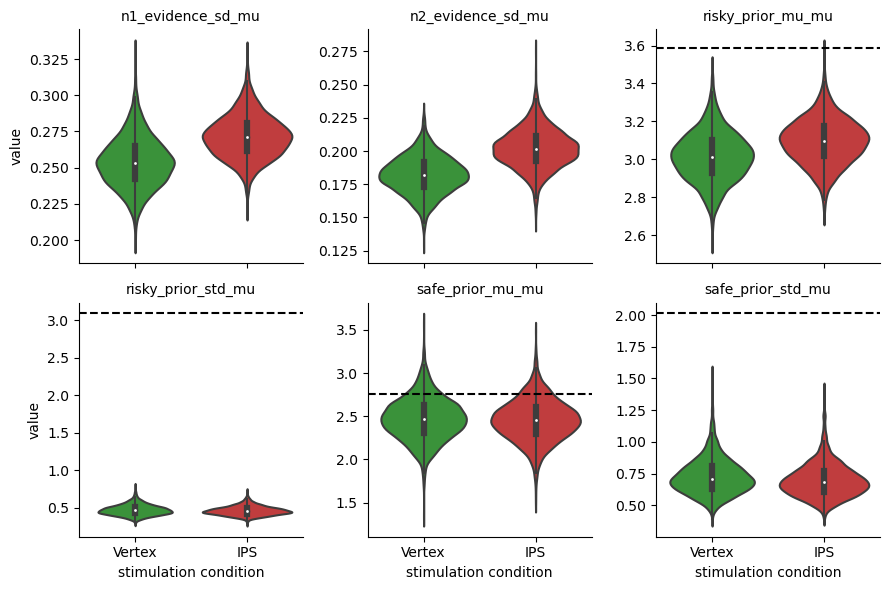

In [7]:
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

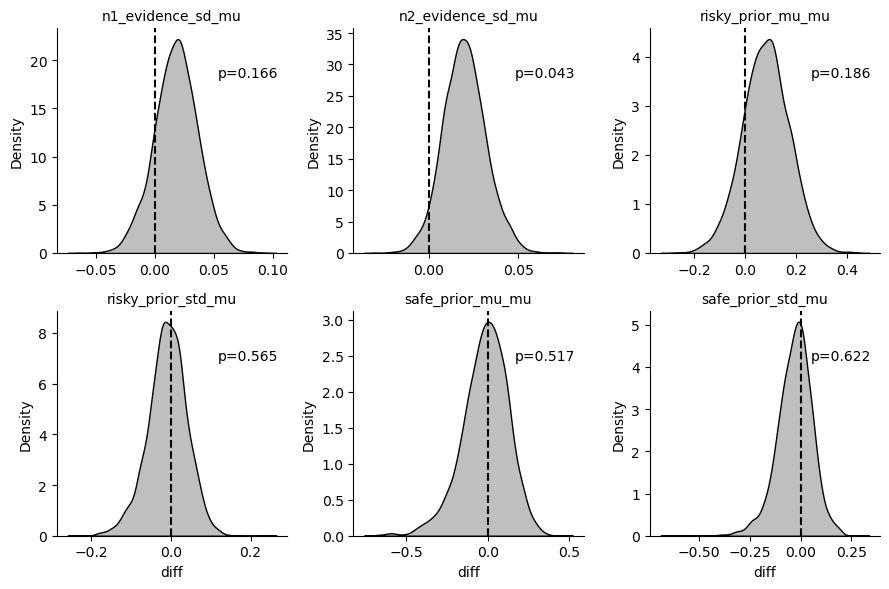

In [8]:
plot_pars_diff(pars)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/3789290814.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/3789290814.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

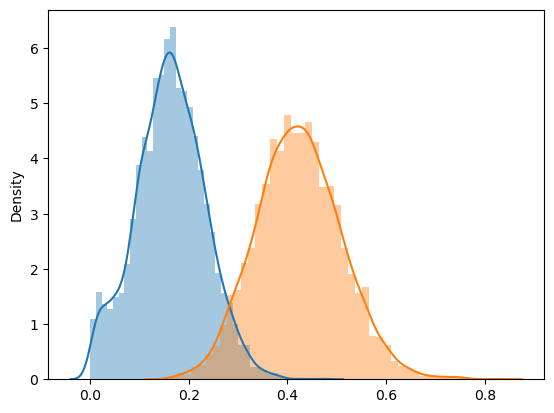

In [9]:
ips_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

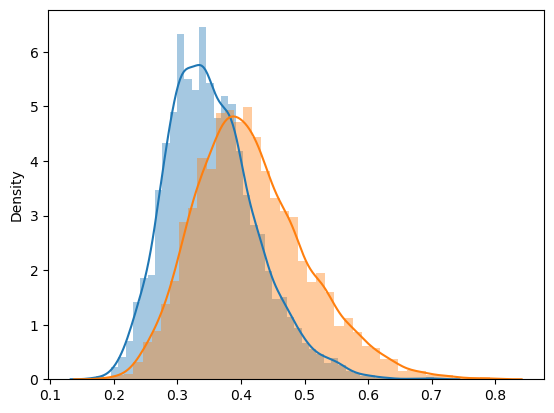

In [10]:
ips_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

In [ ]:
plot_

### PPC

In [ ]:
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

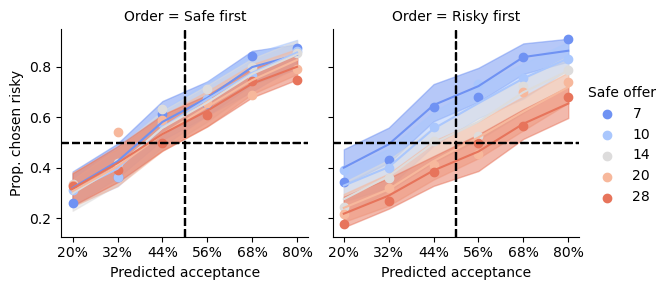

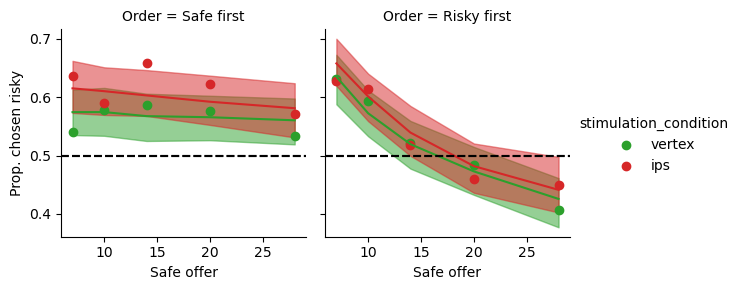

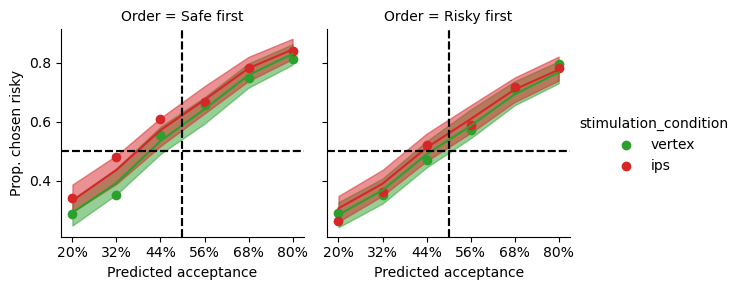

In [ ]:
for plot_type in [5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-1_ppc{plot_type}.pdf'))

# Model 1c

In [ ]:
model_label = '1c'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


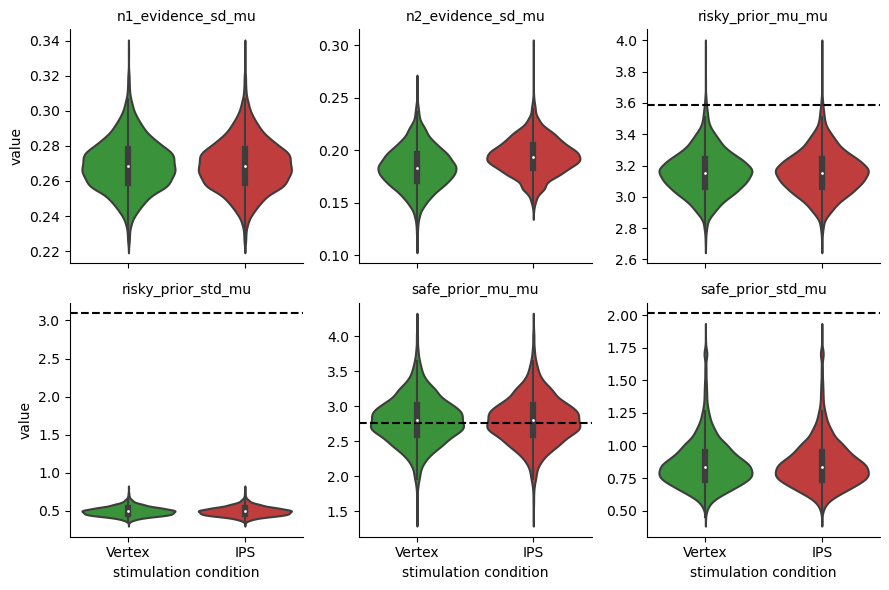

In [ ]:
plot_pars(pars, df)

In [ ]:
plot_pars_diff(pars)

# Model 1: subjectwise

In [4]:
bids_folder  = '/data/ds-tmsrisk'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-1_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

In [5]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

In [6]:
mean_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean()

In [7]:
def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

In [8]:
mean_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

In [9]:
def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)

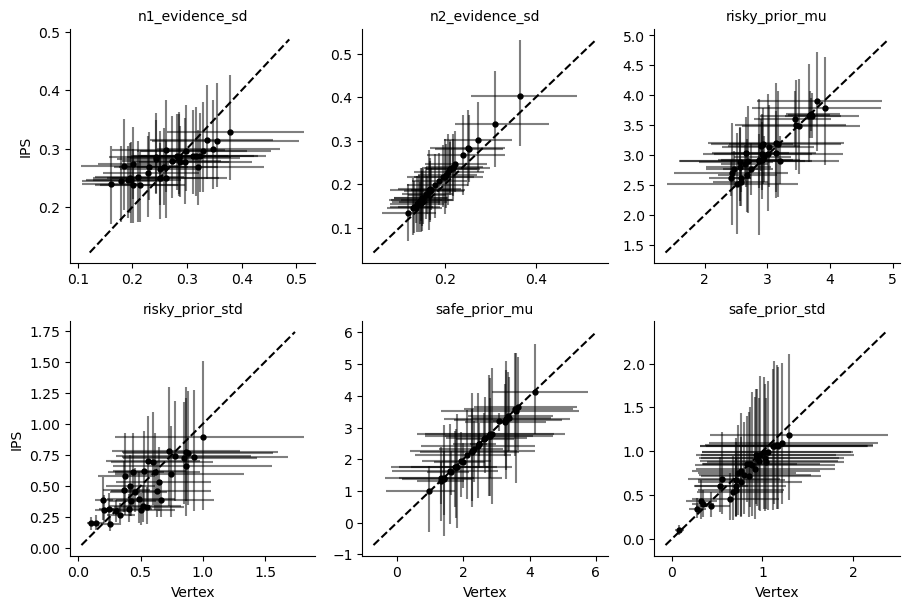

In [11]:
g = sns.FacetGrid(par_stats.unstack(['stimulation condition']).reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map_dataframe(plot_scatter_with_errors, color='k')
g.map(plot_identity_line)
g.set_titles('{col_name}')
# g.set(xlabel='Vertex', ylabel='IPS')
g.set_xlabels('Vertex')
g.set_ylabels('IPS')

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-1_pars_before_after.pdf'))

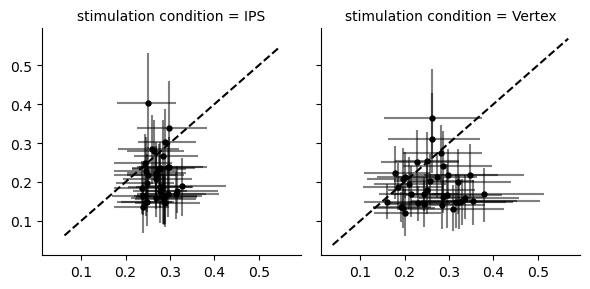

In [20]:
tmp = par_stats.loc[(slice(None), slice(None), ['n1_evidence_sd', 'n2_evidence_sd'])].unstack('parameter')

g = sns.FacetGrid(tmp.reset_index(), col='stimulation condition')
g.map_dataframe(plot_scatter_with_errors, xlabel='n1_evidence_sd', ylabel='n2_evidence_sd', color='k')
g.map(plot_identity_line)

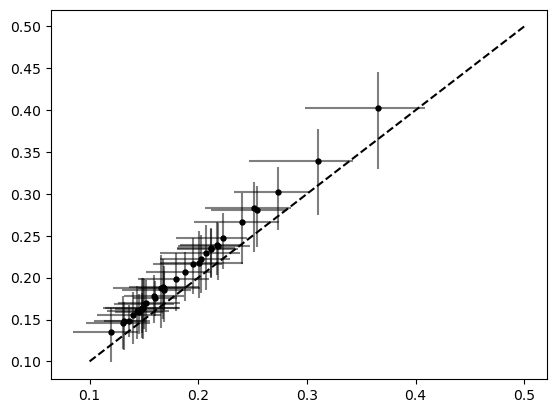

In [23]:
mean_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .67), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

d = par_stats.xs('n2_evidence_sd', 0, 'parameter')
tmp = d.unstack('stimulation condition')

plot_scatter_with_errors(tmp, color='k')
plt.scatter(tmp[('mean', 'Vertex')], tmp[('mean', 'IPS')], marker='.', color='k', s=25)
plt.plot([0.1, 0.5], [0.1, 0.5], c='k', ls='--')

In [28]:
import pingouin
mean_pars.unstack(['parameter'])['mean'][['n1_evidence_sd', 'n2_evidence_sd']].groupby('stimulation condition').apply(lambda d: pingouin.corr(d['n1_evidence_sd'], d['n2_evidence_sd']))

,,n,r,CI95%,p-val,BF10,power
stimulation condition,,,,,,,
IPS,pearson,35,-0.034215,"[-0.36, 0.3]",0.845294,0.214,0.053966
Vertex,pearson,35,-0.027536,"[-0.36, 0.31]",0.875230,0.213,0.052409


In [28]:
from tms_risk.cogmodels.fit_model import get_data, build_model

In [34]:
from tms_risk.cogmodels.fit_model import get_data, build_model
bids_folder
model_label = '1'

data = get_data(bids_folder)
model = build_model('1', data)
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:66: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [37]:
def summarize_ppc(ppc, groupby=None, return_p_chose_risky=True):

    if 

    if groupby is not None:
        ppc = ppc.groupby(groupby).mean()

    e = ppc.mean(1).to_frame('p_predicted')
    hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
                       columns=['hdi025', 'hdi975'])

    return pd.concat((e, hdi), axis=1)

In [47]:
ppc_ = ppc.copy()

In [48]:
ix_risky_first = ppc_.index.get_level_values('risky_first')
ppc_.loc[ix_risky_first] = 1- ppc_.loc[ix_risky_first]

In [8]:
from tms_risk.cogmodels.utils import plot_ppc

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:126: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:81: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


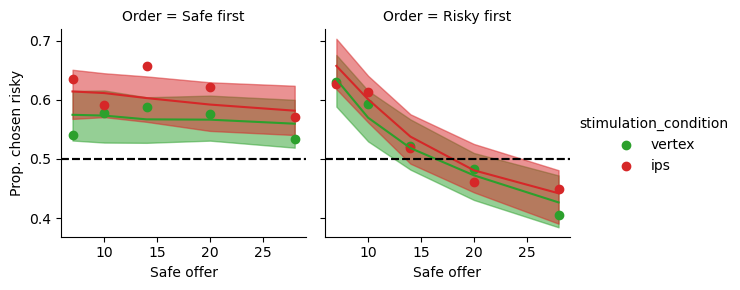

In [51]:
plot_ppc(data, ppc_, plot_type=6, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:126: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:81: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


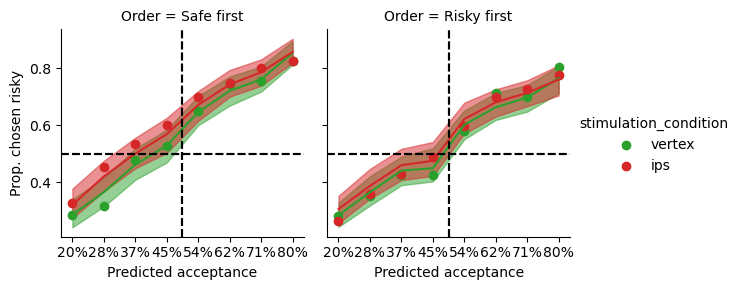

In [52]:
plot_ppc(data, ppc_, plot_type=7, level='group')

# Model 1c

In [28]:
model_label = '1c'
df, model, idata = get_info(model_label)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [55]:
pars = get_pars(idata)

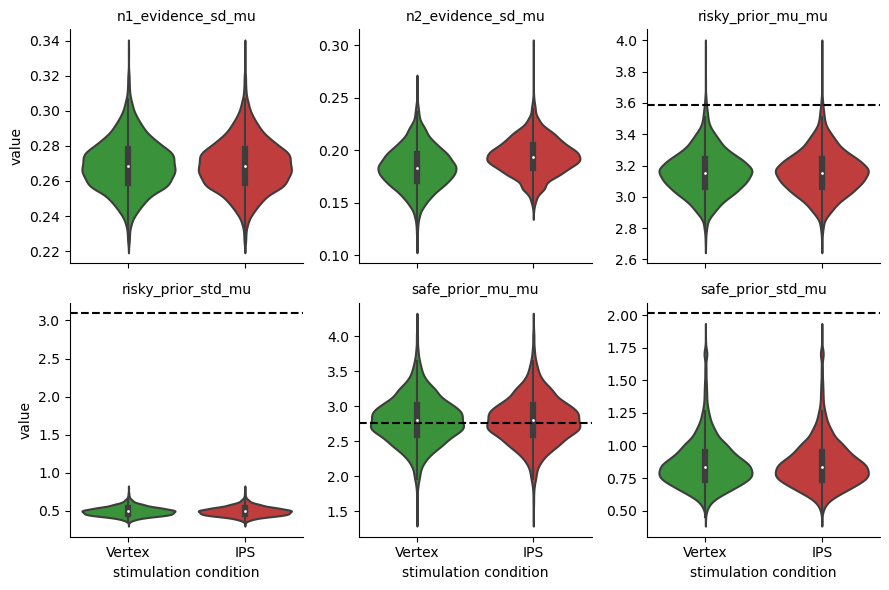

In [61]:

plot_pars(pars, df)

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

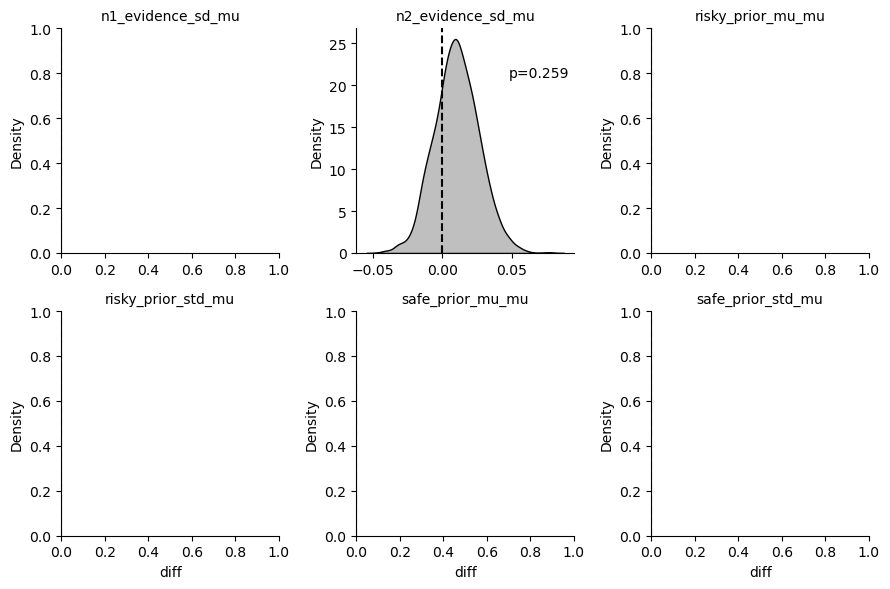

In [62]:
plot_pars_diff(pars)

In [45]:
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


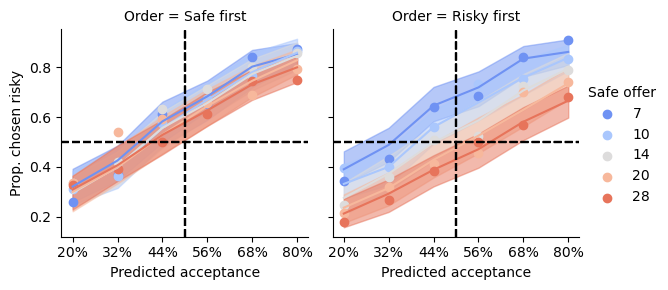

In [48]:
plot_ppc(df, ppc, plot_type=5, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

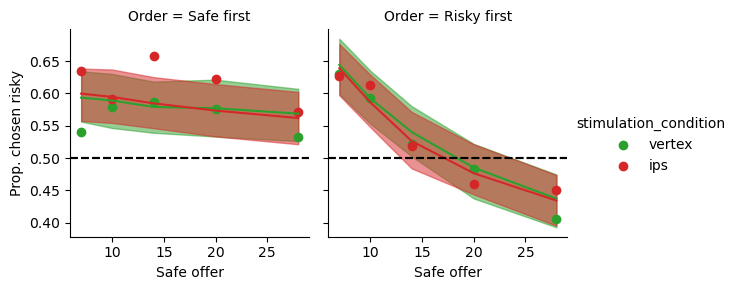

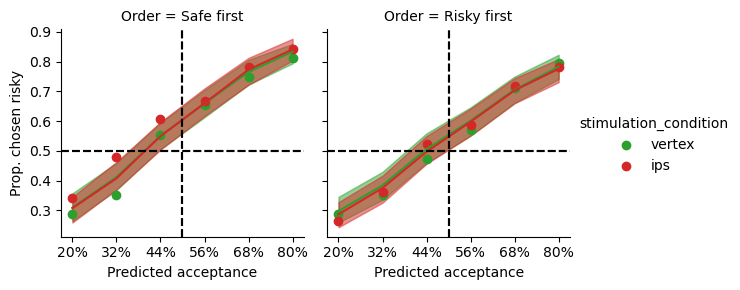

In [51]:
plot_ppc(df, ppc, plot_type=6, level='group')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-1c_ppc6.pdf'))

plot_ppc(df, ppc, plot_type=7, level='group')
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-1c_ppc7.pdf'))

# Model 5

In [12]:
bids_folder  = '/data/ds-tmsrisk'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-5_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

In [13]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['perceptual_noise_sd', 'memory_noise_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')

    if key in ['perceptual_noise_sd', 'memory_noise_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

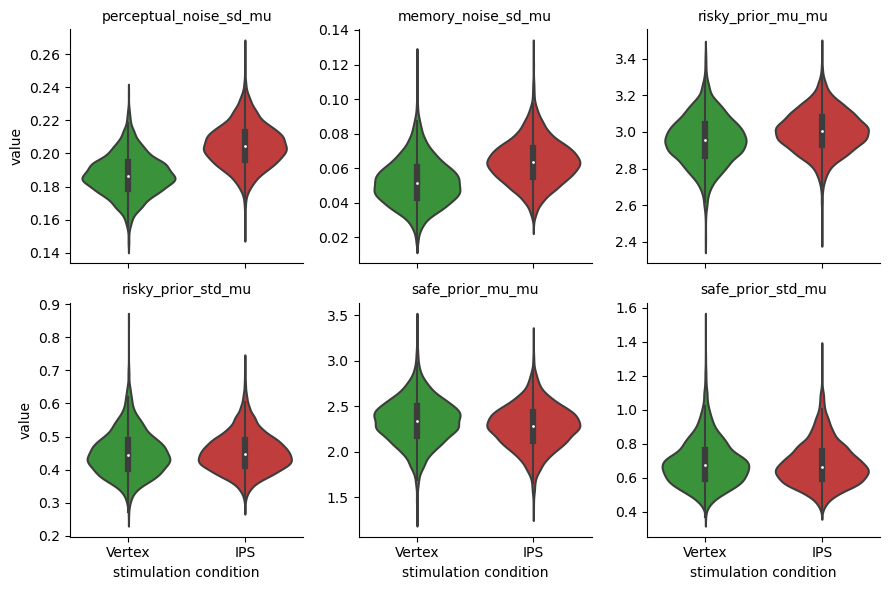

In [14]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

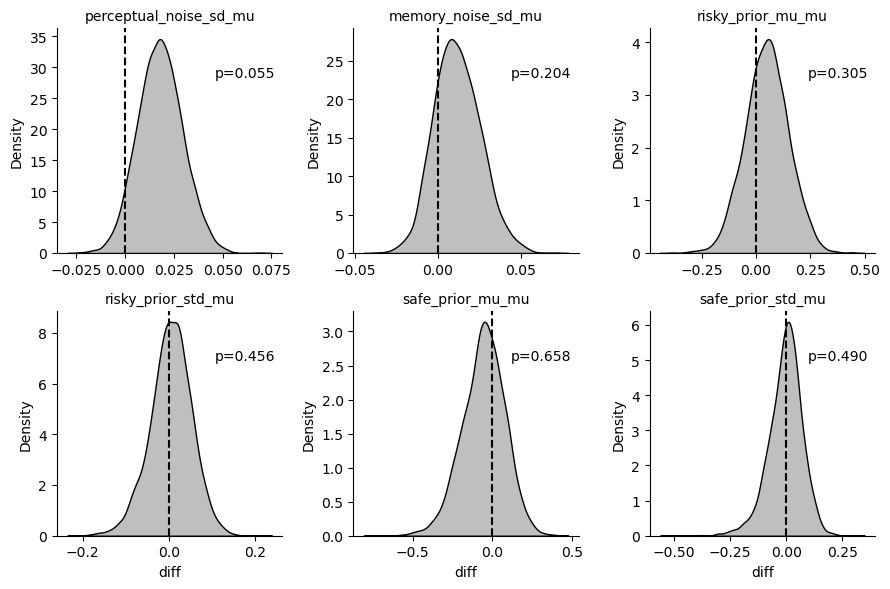

In [15]:
tmp = pars.unstack('stimulation condition')['value']
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

## Subject level

In [7]:
bids_folder  = '/data/ds-tmsrisk'

# idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', 'model-5_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

In [8]:
traces = {}

pars_vertex = []
pars_ips = []

keys = ['memory_noise_sd', 'perceptual_noise_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    
    if 'stimulation_condition[T.vertex]' in traces[key].index.unique(level=f'{key}_regressors'):
        vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
    else:
        vertex_values = ips_values 

    if key in ['memory_noise_sd', 'perceptual_noise_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

In [9]:
mean_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean().to_frame('mean')
ci_pars = pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

par_stats = mean_pars.join(ci_pars)

In [10]:
def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)

def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

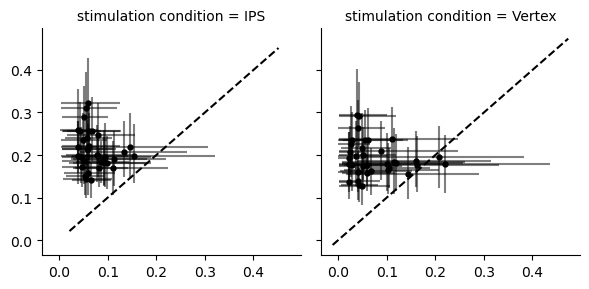

In [11]:
tmp = par_stats.loc[(slice(None), slice(None), ['memory_noise_sd', 'perceptual_noise_sd'])].unstack('parameter')

g = sns.FacetGrid(tmp.reset_index(), col='stimulation condition')
g.map_dataframe(plot_scatter_with_errors, xlabel='memory_noise_sd', ylabel='perceptual_noise_sd', color='k')
g.map(plot_identity_line)

In [16]:
from tms_risk.cogmodels.fit_model import get_data, build_model
bids_folder
model_label = '5'

data = get_data(bids_folder)
model = build_model(model_label, data)
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


AttributeError: 'NoneType' object has no attribute 'startswith'

In [ ]:
from tms_risk.cogmodels.utils import plot_ppc

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


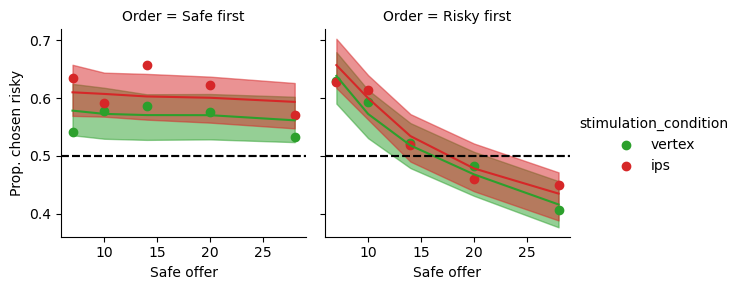

In [15]:
plot_ppc(data, ppc, plot_type=6, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


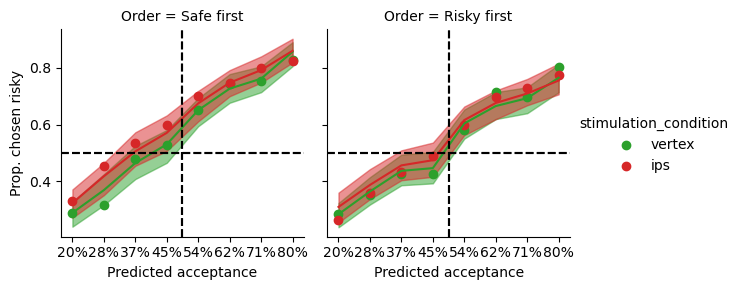

In [16]:
plot_ppc(data, ppc, plot_type=7, level='group')

# Model 5a

In [3]:
bids_folder  = '/data/ds-tmsrisk'
model_label = '5a'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

traces = {}

pars_vertex = []
pars_ips = []

keys = ['memory_noise_sd', 'perceptual_noise_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    
    if 'stimulation_condition[T.vertex]' in traces[key].index.unique(level=f'{key}_regressors'):
        vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
    else:
        vertex_values = ips_values 

    if key in ['memory_noise_sd', 'perceptual_noise_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

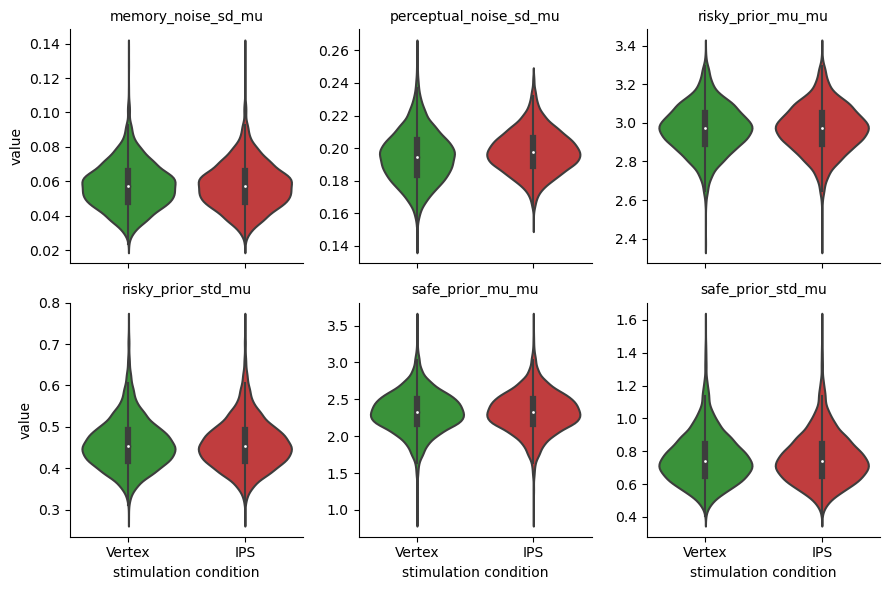

In [4]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

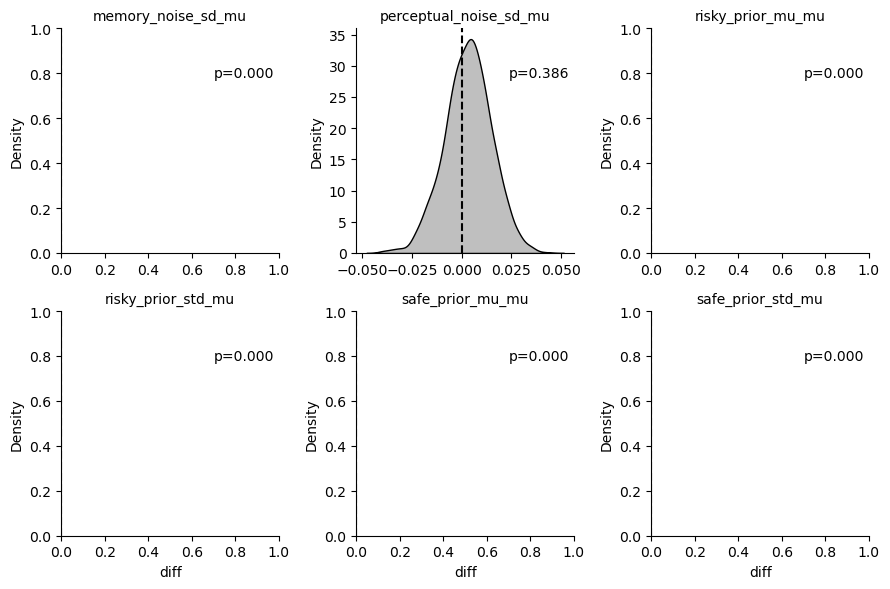

In [5]:
tmp = pars.unstack('stimulation condition')['value']
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

In [6]:
from tms_risk.cogmodels.fit_model import get_data, build_model
data = get_data(bids_folder)
model = build_model(model_label, data)
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


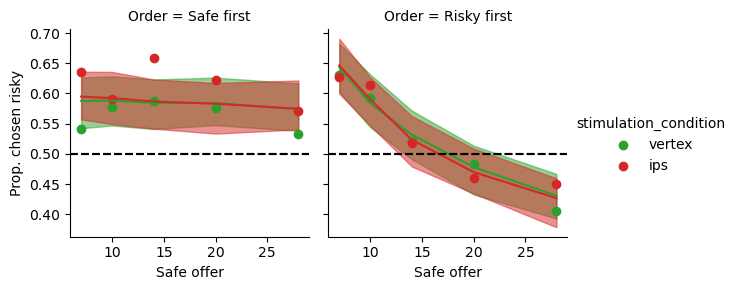

In [10]:
plot_ppc(data, ppc, plot_type=6, level='group')

# Model 6 

In [22]:
bids_folder  = '/data/ds-tmsrisk'
model_label = '6'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

In [23]:
idata.posterior.keys()

KeysView(<xarray.Dataset>
Dimensions:                     (chain: 4, draw: 1000,
                                 n1_evidence_sd_regressors: 1, subject: 35,
                                 n2_evidence_sd_regressors: 1,
                                 risky_prior_mu_regressors: 2,
                                 risky_prior_std_regressors: 2,
                                 safe_prior_mu_regressors: 2,
                                 safe_prior_std_regressors: 2,
                                 evidence_sd_regressors: 1, p_dim_0: 8335)
Coordinates:
  * chain                       (chain) int64 0 1 2 3
  * draw                        (draw) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * n1_evidence_sd_regressors   (n1_evidence_sd_regressors) object 'Intercept'
  * subject                     (subject) int64 1 2 3 4 5 6 ... 63 67 69 72 74
  * n2_evidence_sd_regressors   (n2_evidence_sd_regressors) object 'Intercept'
  * risky_prior_mu_regressors   (risky_prior_mu_regressors) object '

In [27]:
idata.posterior['evidence_sd'].to_dataframe()

evidence_sd
chain draw subject evidence_sd_regressors              
0     0    1       stimulation_condition01     0.016192
           2       stimulation_condition01     0.047716
           3       stimulation_condition01     0.043998
           4       stimulation_condition01     0.123371
           5       stimulation_condition01     0.078319
...                                                 ...
3     999  63      stimulation_condition01     0.295967
           67      stimulation_condition01    -0.114033
           69      stimulation_condition01     0.223852
           72      stimulation_condition01    -0.024871
           74      stimulation_condition01    -0.195876

[140000 rows x 1 columns]

In [29]:
ips_values[key+'_mu']

chain  draw
0      0      -1.223879
       1      -1.271626
       2      -1.277502
       3      -1.197107
       4      -1.269018
                 ...   
3      995    -1.202651
       996    -1.168129
       997    -1.294649
       998    -1.241705
       999    -1.111940
Name: n1_evidence_sd_mu, Length: 4000, dtype: float64

In [30]:
idata.posterior['evidence_sd'].to_dataframe()['evidence_sd']

chain  draw  subject  evidence_sd_regressors 
0      0     1        stimulation_condition01    0.016192
             2        stimulation_condition01    0.047716
             3        stimulation_condition01    0.043998
             4        stimulation_condition01    0.123371
             5        stimulation_condition01    0.078319
                                                   ...   
3      999   63       stimulation_condition01    0.295967
             67       stimulation_condition01   -0.114033
             69       stimulation_condition01    0.223852
             72       stimulation_condition01   -0.024871
             74       stimulation_condition01   -0.195876
Name: evidence_sd, Length: 140000, dtype: float64

In [33]:
idata.posterior['evidence_sd_mu'].to_dataframe()['evidence_sd_mu']

chain  draw  evidence_sd_regressors 
0      0     stimulation_condition01    0.057209
       1     stimulation_condition01    0.113436
       2     stimulation_condition01    0.139611
       3     stimulation_condition01    0.039935
       4     stimulation_condition01    0.076820
                                          ...   
3      995   stimulation_condition01    0.060355
       996   stimulation_condition01    0.028276
       997   stimulation_condition01    0.132073
       998   stimulation_condition01    0.099859
       999   stimulation_condition01    0.059961
Name: evidence_sd_mu, Length: 4000, dtype: float64

In [34]:
stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    
    if 'stimulation_condition[T.vertex]' in traces[key].index.unique(level=f'{key}_regressors'):
        vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
    elif key in ['n1_evidence_sd', 'n2_evidence_sd']:
        vertex_values = ips_values.copy()
        ips_values[key+'_mu'] += idata.posterior['evidence_sd_mu'].to_dataframe()['evidence_sd_mu'].droplevel(-1)
    else:
        vertex_values = ips_values 


    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

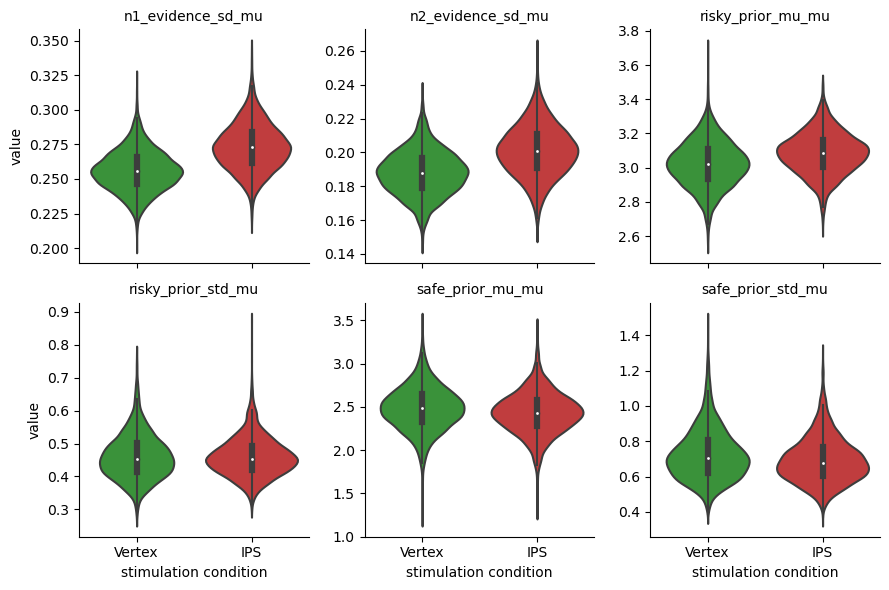

In [35]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

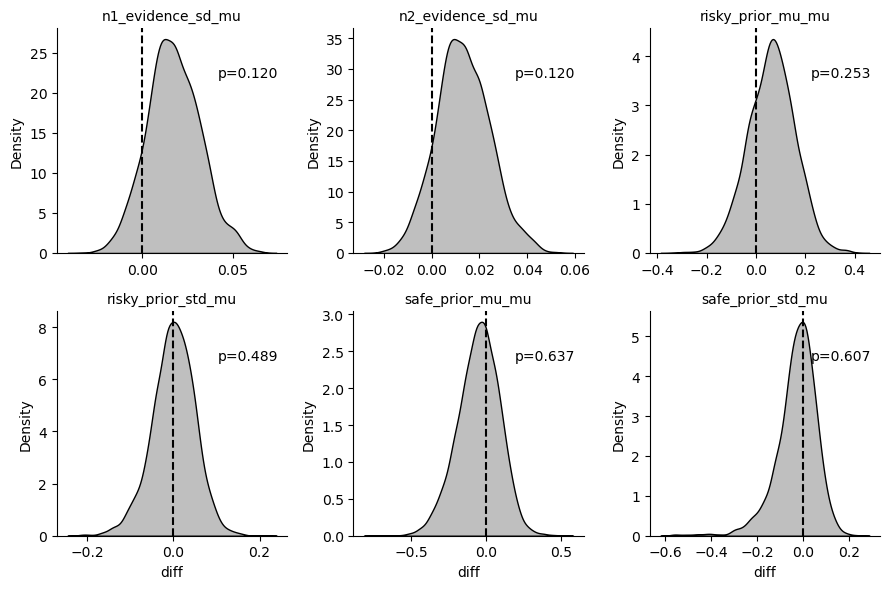

In [36]:
tmp = pars.unstack('stimulation condition')['value']
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

In [ ]:
from tms_risk.cogmodels.utils import plot_ppc
plot_ppc(data, ppc, plot_type=6, level='group')
plot_ppc(data, ppc, plot_type=7, level='group')

# Model 6a

In [3]:
bids_folder  = '/data/ds-tmsrisk'
model_label = '6a'

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

In [4]:

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']

traces = {}

pars_vertex = []
pars_ips = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    
    if key in ['n1_evidence_sd', 'n2_evidence_sd']:
        vertex_values = ips_values.copy()
        ips_values[key+'_mu'] += idata.posterior['evidence_sd_mu'].to_dataframe()['evidence_sd_mu'].values

    else:
        if 'stimulation_condition[T.vertex]' in traces[key].index.unique(level=f'{key}_regressors'):
            vertex_values[key] = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')['evidence_sd']
        else:
            vertex_values = ips_values 

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        ips_values = softplus_np(ips_values)
        vertex_values = softplus_np(vertex_values)

    pars_ips.append(ips_values)
    pars_vertex.append(vertex_values)


pars_ips = pd.concat(pars_ips, axis=1)
pars_vertex = pd.concat(pars_vertex, axis=1)

pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

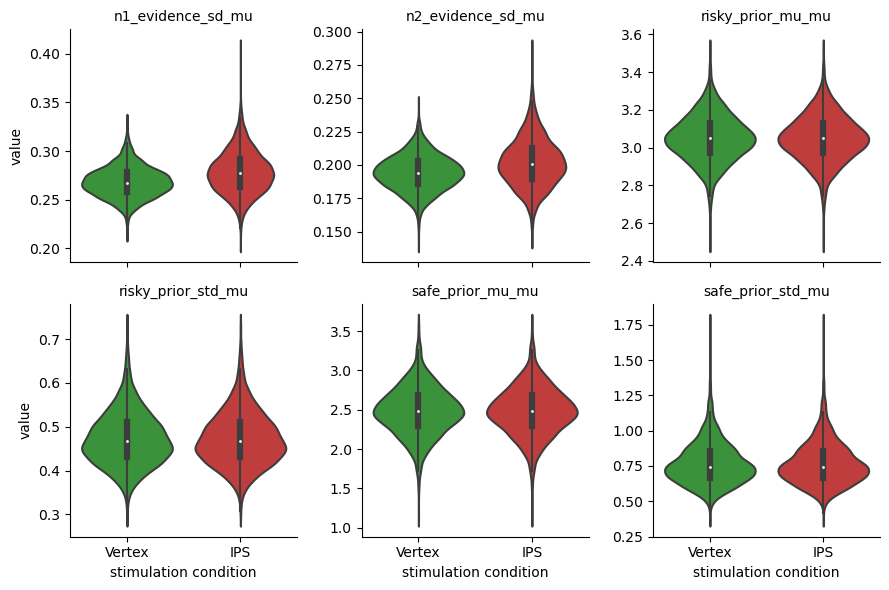

In [5]:
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
g.set_titles('{col_name}')

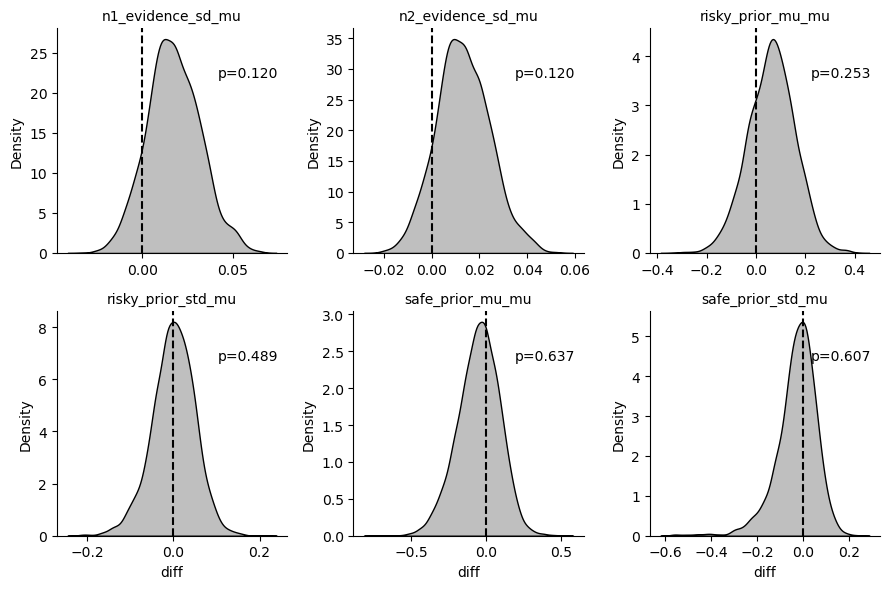

In [50]:
tmp = pars.unstack('stimulation condition')['value']
tmp = tmp['IPS'] - tmp['Vertex']
g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

g.map(sns.kdeplot, 'diff', fill=True, color='k')

g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

g.set_titles('{col_name}')

for ax, par in zip(g.axes.flat, g.col_names):
    p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
    ax.text(0.7, 0.8, f'p={p:0.3f}',
    horizontalalignment='left',
     fontsize=10,
     verticalalignment='center',
     transform = ax.transAxes)

In [53]:
idata.posterior['evidence_sd_mu'].to_dataframe()

evidence_sd_mu
chain draw evidence_sd_regressors                 
0     0    stimulation_condition01        0.057209
      1    stimulation_condition01        0.113436
      2    stimulation_condition01        0.139611
      3    stimulation_condition01        0.039935
      4    stimulation_condition01        0.076820
...                                            ...
3     995  stimulation_condition01        0.060355
      996  stimulation_condition01        0.028276
      997  stimulation_condition01        0.132073
      998  stimulation_condition01        0.099859
      999  stimulation_condition01        0.059961

[4000 rows x 1 columns]

In [8]:
from tms_risk.cogmodels.fit_model import get_data, build_model
data = get_data(bids_folder, model_label)
model = build_model(model_label, data)
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=data)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
yo
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


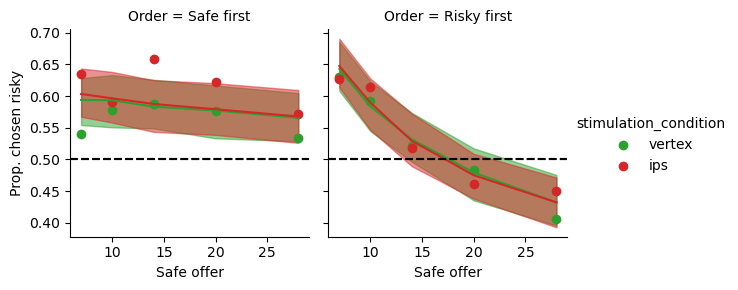

In [10]:
from tms_risk.cogmodels.utils import plot_ppc
plot_ppc(data, ppc, plot_type=6, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


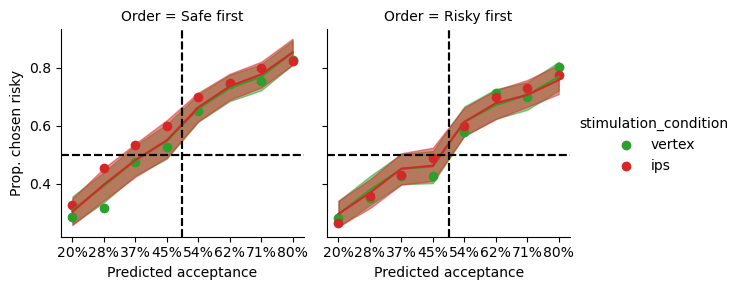

In [12]:
plot_ppc(data, ppc, plot_type=7, level='group')

# Model 7

In [5]:
model_label = '7'
df, model, idata = get_info(model_label)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


In [6]:
def apply_dm(beta):

    if beta.shape[1] == 4:
        x = np.zeros((4, 4))
        x[:, 0] = 1
        x[1, 1] = 1
        x[3, 1] = 1
        x[2:, 2] = 1
        x[3:, 3] = 1

        x = pd.DataFrame(x, columns=beta.columns, index=pd.MultiIndex.from_tuples([('ips', 'safe first'), ('ips', 'risky first'), ('vertex', 'safe first'), ('vertex', 'risky first')],
        names=['stimulation_condition', 'order']))

        print(x)

    return beta.dot(x.T).T

def get_conditional_parameters(idata, key, group=True):

    if group:
        key_ = key+'_mu'

    beta = idata.posterior[key_].to_dataframe().unstack(f'{key}_regressors')

    y = apply_dm(beta)

    y = y.stack([0, 1]).to_frame(key_) 

    if key in ['n1_evidence_sd', 'n2_evidence_sd']:
        return softplus_np(y)
    else:
        return y


                                  n1_evidence_sd_mu                      \
n1_evidence_sd_regressors                 Intercept risky_first[T.True]   
stimulation_condition order                                               
ips                   safe first                1.0                 0.0   
                      risky first               1.0                 1.0   
vertex                safe first                1.0                 0.0   
                      risky first               1.0                 1.0   

                                                                   \
n1_evidence_sd_regressors         stimulation_condition[T.vertex]   
stimulation_condition order                                         
ips                   safe first                              0.0   
                      risky first                             0.0   
vertex                safe first                              1.0   
                      risky first                           

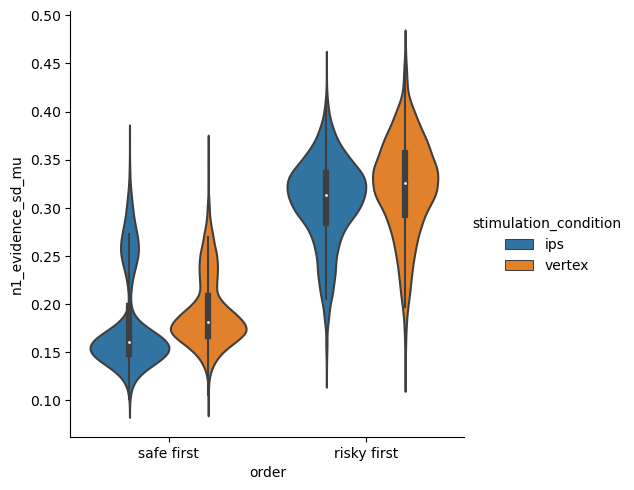

In [7]:
n1_evidence_sd = get_conditional_parameters(idata, 'n1_evidence_sd')
sns.catplot(x='order', y='n1_evidence_sd_mu', hue='stimulation_condition', data=n1_evidence_sd.reset_index(), kind='violin')

                                  n2_evidence_sd_mu                      \
n2_evidence_sd_regressors                 Intercept risky_first[T.True]   
stimulation_condition order                                               
ips                   safe first                1.0                 0.0   
                      risky first               1.0                 1.0   
vertex                safe first                1.0                 0.0   
                      risky first               1.0                 1.0   

                                                                   \
n2_evidence_sd_regressors         stimulation_condition[T.vertex]   
stimulation_condition order                                         
ips                   safe first                              0.0   
                      risky first                             0.0   
vertex                safe first                              1.0   
                      risky first                           

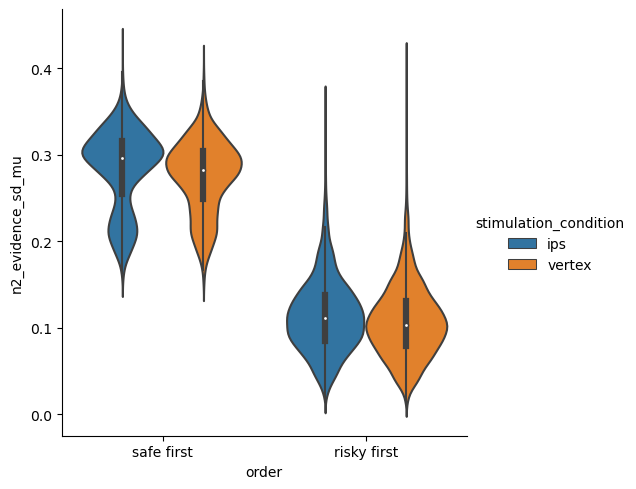

In [8]:
n2_evidence_sd = get_conditional_parameters(idata, 'n2_evidence_sd')
sns.catplot(x='order', y='n2_evidence_sd_mu', hue='stimulation_condition', data=n2_evidence_sd.reset_index(), kind='violin')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_56369/686696447.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.histplot(n1_evidence_sd.loc[('ips', 'safe first')] - n1_evidence_sd.loc[('vertex', 'safe first')])


<Axes: ylabel='Count'>

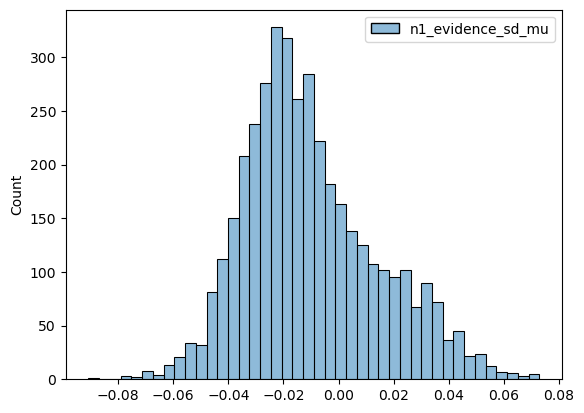

In [9]:
sns.histplot(n1_evidence_sd.loc[('ips', 'safe first')] - n1_evidence_sd.loc[('vertex', 'safe first')])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_56369/1843353906.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.histplot(n1_evidence_sd.loc[('ips', 'risky first')] - n1_evidence_sd.loc[('vertex', 'risky first')])


<Axes: ylabel='Count'>

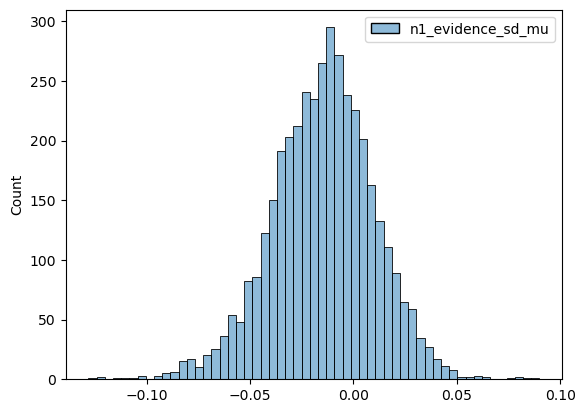

In [10]:
sns.histplot(n1_evidence_sd.loc[('ips', 'risky first')] - n1_evidence_sd.loc[('vertex', 'risky first')])

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_56369/2628825921.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  sns.histplot(n2_evidence_sd.loc[('ips', 'risky first')] - n2_evidence_sd.loc[('vertex', 'risky first')])


<Axes: ylabel='Count'>

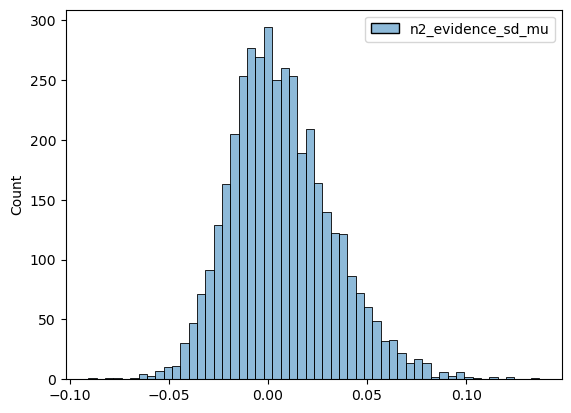

In [11]:
sns.histplot(n2_evidence_sd.loc[('ips', 'risky first')] - n2_evidence_sd.loc[('vertex', 'risky first')])

In [12]:
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


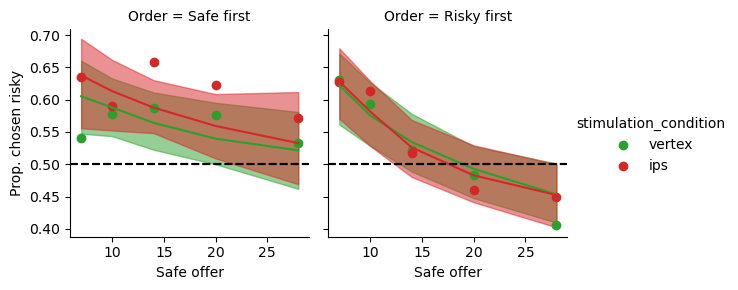

In [14]:
from tms_risk.cogmodels.utils import plot_ppc
plot_ppc(df, ppc, plot_type=6, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


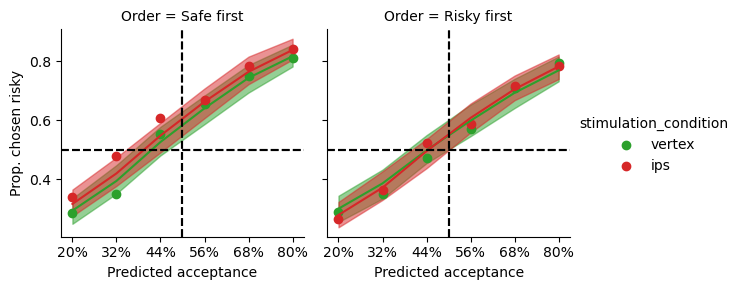

In [15]:
from tms_risk.cogmodels.utils import plot_ppc
plot_ppc(df, ppc, plot_type=7, level='group')

/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


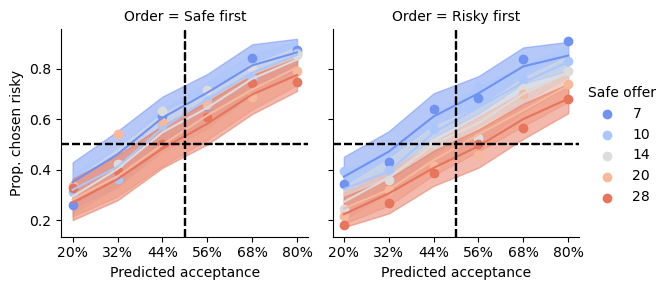

In [16]:
plot_ppc(df, ppc, plot_type=5, level='group')